<a href="https://colab.research.google.com/github/illhyhl1111/SNU_ML2019/blob/master/Lab1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Logic Gate Example

In [0]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

#### class Separator
- variables : a,b,c (initialize with Norm(0,1))
- func : activation functions (such as sigmoid, relu, except softmax)
- inputs : x,y point
- output : val_

In [0]:
class Separator(nn.Module):
  def __init__(self, func = None):
    super(Separator, self).__init__()
    self.a = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    self.b = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    self.c = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    if func is not None:
      self.func = func
    else:
      self.func = torch.sigmoid
    
  def forward(self,x,y):
    val_ = self.func(self.a * x + self.b * y - self.c)
    return val_, (self.a.item(), self.b.item(), self.c.item())

#### dataset DataGenerator
- dataset : (x,y), validate
- x,y are picked from {0,1} with gaussian error N(0,0.5^2)

In [0]:
class DataGenerator(Dataset):
  
  def __init__(self,type_,length,custom=None):
    self.length=length
    if type_ == 'and':
      self.val_l = [0,0,0,1]
    elif type_ == 'or':
      self.val_l = [0,1,1,1]
    elif type_ == 'xor':
      self.val_l = [0,1,1,0]
    elif type_ == 'custom' and custom is not None:
      self.val_l = custom
    else:
      self.val_l = [0,0,0,0]
      
    self.dataset = []
    for i in range(length):
      x = np.random.normal(i%2,0.16)
      y = np.random.normal((i//2)%2,0.16)
      val = self.val_l[i%4]
      self.dataset.append((x,y,val))

  def get_dataset(self):
    return self.dataset
      
  def __len__(self):
    return self.length
            
  def __getitem__(self,idx):
    x,y,val = self.dataset[idx]
    return (torch.Tensor([x]),torch.Tensor([y]), torch.Tensor([val]))

#### Hyperparameters & Dataset


In [0]:
DATASET = DataGenerator('xor',1000)
LEARNING_RATE = 0.01
BATCH_SIZE = 20
NUM_EPOCHES = 20
NUM_WORKERS = 4
GRAPH_X = np.linspace(-1.0,2,2)

params = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'num_workers': 4,
}

dataloader = DataLoader(DATASET,**params)
model = Separator().cuda()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

#### Training part

Loss : 0.28978
Loss : 0.28737
Loss : 0.28519
Loss : 0.28139
Loss : 0.27412


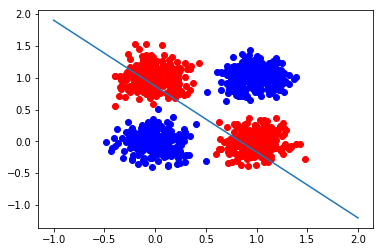

Loss : 0.26537
Loss : 0.25933
Loss : 0.25491
Loss : 0.25313
Loss : 0.25173


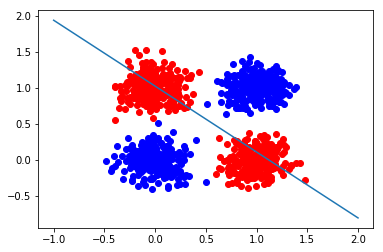

Loss : 0.25120
Loss : 0.25102
Loss : 0.25095
Loss : 0.25078
Loss : 0.25084


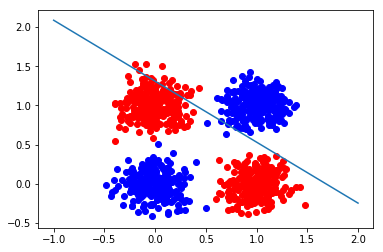

Loss : 0.25079
Loss : 0.25032
Loss : 0.25104
Loss : 0.25104
Loss : 0.25042


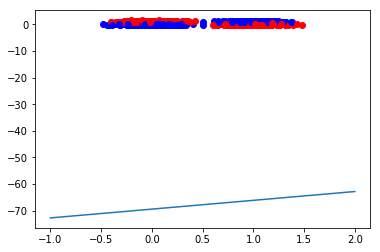

In [120]:
for epoch in range(NUM_EPOCHES):
  tot_loss = 0
  for x, y, val in dataloader:
    x = x.cuda()
    y = y.cuda()
    val = val.cuda()
    optimizer.zero_grad()
    val_, params = model(x,y)
    loss = torch.sum(torch.pow(val-val_,2))
    
    loss.backward()
    optimizer.step()
    tot_loss+=loss.item()
  print("Loss : {:.5f}".format(tot_loss/len(DATASET)))

  if epoch % 5 == 4:
    for item in DATASET.get_dataset():
      x,y,val = item
      if val ==1:
        plt.scatter(x,y,c='red')
      else:
        plt.scatter(x,y,c='blue')
    plt.plot(GRAPH_X,-(GRAPH_X*params[0]-params[2])/(params[1]+1e-10))
    plt.show()